# Benchmark creation with [Polaris](https://github.com/polaris-hub/polaris)
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <01_polaris_adme-fang-1_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

The resulting benchmarks can be found in Polaris:
- [biogen/adme-fang-hclint-1](https://polarishub.io/benchmarks/biogen/adme-fang-hclint-1)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import datamol as dm
import numpy as np

from sklearn.model_selection import ShuffleSplit

# polaris benchmark
from polaris.benchmark import (
    MultiTaskBenchmarkSpecification,
)

# polaris hub
from polaris.cli import PolarisHubClient
from polaris.utils.types import HubOwner

# utils
root = pathlib.Path("__file__").absolute().parents[3]
os.chdir(root)
sys.path.insert(0, str(root))
from utils.docs_utils import load_readme

In [6]:
# Get the owner and organization
org = "biogen"
data_name = "fang2023_ADME"
dataset_version = "v2"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"


owner = HubOwner(slug=org, type="organization")
owner

BENCHMARK_DIR = f"{gcp_root}/benchmarks"
DATASET_JSON = f"gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/datasets/adme-fang-{dataset_version}/dataset.json"

FIGURE_DIR = f"{gcp_root}/figures"

## Load existing Dataset
> **Attention:** \
> See more dataset creataion details in [02_polaris_adme-fang_dataset.ipynb](https://github.com/polaris-hub/polaris-recipes/org-Biogen/fang2023_ADME/02_polaris_adme-fang_dataset.ipynb).

In [7]:
# Load the saved Dataset
from polaris.dataset import Dataset

dataset = Dataset.from_json(DATASET_JSON)

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test splits, and defining evaluation metrics to establish a baseline performance level.

In [8]:
table = dataset.table
mol_col = "MOL_smiles"

### Multitask learning benchmark for all the six ADME endpoints which share one train/test split. 

In [9]:
# regression
TEST_SIZE = 0.2
SEED = 111

# random split
random_splitter = ShuffleSplit(n_splits=5, test_size=TEST_SIZE, random_state=SEED)
random_split = next(random_splitter.split(X=table[mol_col].values))
split_key = "random"

### Check distribution of train/test set in the chemical space

  0%|          | 0/3521 [00:00<?, ?it/s]

'https://storage.googleapis.com/polaris-public/polaris-recipes/org-biogen/fang2023_ADME/figures/multitask_random_chemspace.png'

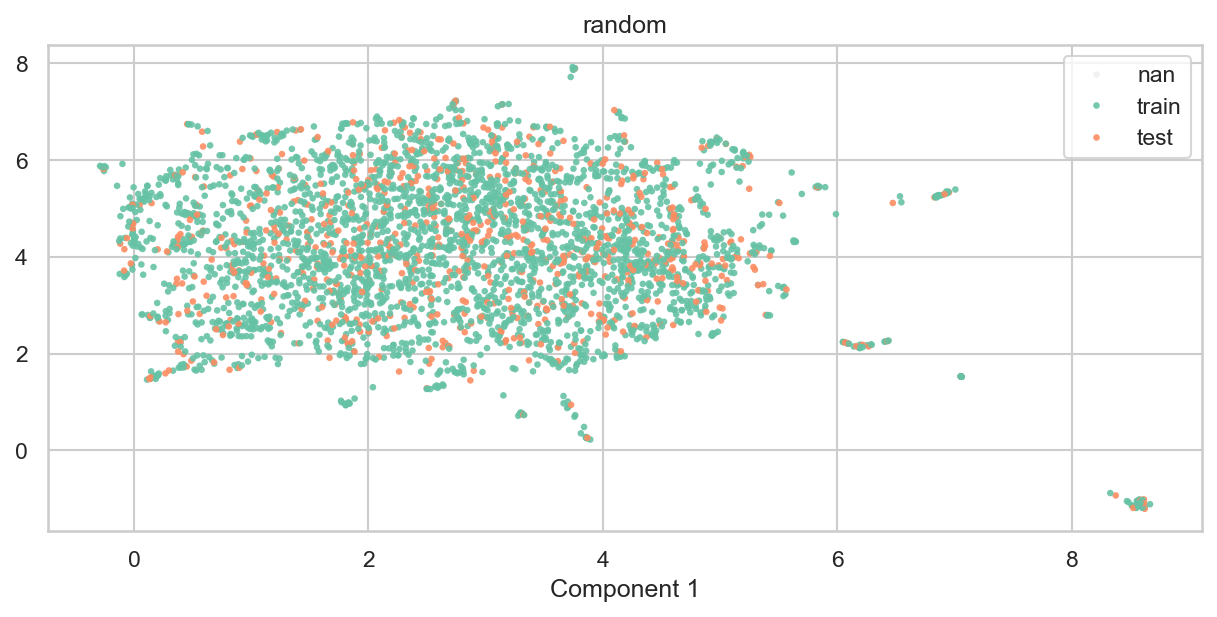

In [10]:
from utils.docs_utils import visualize_split_chemspace
from utils.auroris_utils import save_image

fig = visualize_split_chemspace(table[mol_col], {split_key: random_split})
save_image(fig, dm.fs.join(FIGURE_DIR, f"multitask_{split_key}_chemspace.png"))

In [13]:
benchmark_version = "v2"
benchmark_name = f"adme-fang-reg-{benchmark_version}"
readme_name = f"fang2023_ADME_public_multitask_reg_{benchmark_version}"

data_cols = [
    "LOG_HLM_CLint",
    "LOG_RLM_CLint",
    "LOG_MDR1-MDCK_ER",
    "LOG_HPPB",
    "LOG_RPPB",
    "LOG_SOLUBILITY",
]

In [14]:
benchmark_multi = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    target_type="regression",
    input_cols=mol_col,
    split=random_split,
    tags=["adme", "multitask"],
    owner=owner,
    description="A multitask benchmark for six ADME endpoints, utilizing a shared random split. ",
    main_metric="mean_squared_error",
    metrics=[
        "mean_absolute_error",
        "mean_squared_error",
        "r2",
        "spearmanr",
        "pearsonr",
        "explained_var",
    ],
    readme=load_readme(f"org-Biogen/fang2023_ADME/benchmarks/{readme_name}_readme.md"),
)
SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_multi.to_json(SAVE_DIR)
print(path)

# upload to polaris hub
from polaris.hub.client import PolarisHubClient

client = PolarisHubClient()
client.login()
client.upload_benchmark(benchmark=benchmark_multi, access="private", owner=owner)

2024-07-30 13:39:34.650 | INFO     | polaris.mixins._checksum:md5sum:27 - Computing the checksum. This can be slow for large datasets.
2024-07-30 13:39:36.707 | SUCCESS  | polaris.hub.client:login:260 - You are successfully logged in to the Polaris Hub.


gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/benchmarks/adme-fang-reg-v2/benchmark.json
✅ SUCCESS: Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/biogen/adme-fang-reg-v2
 


/Users/lu.zhu/miniconda3/envs/po_dataset/lib/python3.12/site-packages/yaspin/core.py:228: UserWarning: color, on_color and attrs are not supported when running in jupyter
  self._color = self._set_color(value) if value else value


{'id': 'v4hQvf485pjop6BTToo8n',
 'createdAt': '2024-07-30T17:39:36.888Z',
 'deletedAt': None,
 'name': 'adme-fang-reg-v2',
 'slug': 'adme-fang-reg-v2',
 'description': 'A multitask benchmark for six ADME endpoints, utilizing a shared random split. ',
 'tags': ['adme', 'multitask'],
 'userAttributes': {},
 'access': 'private',
 'isCertified': False,
 'polarisVersion': '0.7.9',
 'readme': "![ADME](https://storage.googleapis.com/polaris-public/icons/icons8-whale-96-ADME.png) \n\n## Background\n\nThe goal of assessing ADME properties is to understand how a potential drug candidate interacts with the human body, including absorption, distribution, metabolism, and excretion. This understanding is essential for evaluating the drug's efficacy, safety, and clinical potential, guiding drug development towards optimal therapeutic outcomes. [Fang et al. (2023)](https://doi.org/10.1021/acs.jcim.3c00160) disclosed DMPK datasets collected over 20 months, covering six ADME in vitro endpoints: human an